# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.087236,True,3.289633
1,1.559715,True,9.004853
2,-1.404116,False,-0.595819
3,-1.618095,True,2.805538
4,0.612480,True,3.862305
...,...,...,...
995,-1.018656,False,-1.217888
996,-1.294135,False,-1.144360
997,-0.270946,False,-1.367526
998,0.854117,True,6.127323


<AxesSubplot:xlabel='v0'>

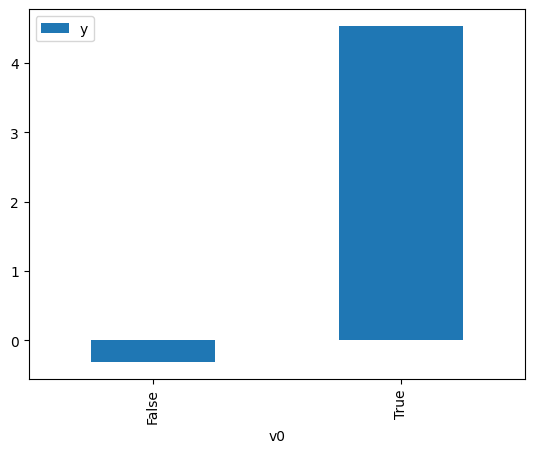

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

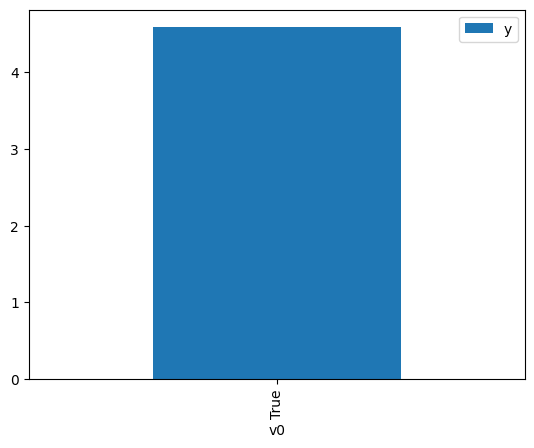

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.661607,False,-1.480154,0.929650,1.075674
1,0.243404,False,0.586330,0.411918,2.427669
2,-0.512787,False,2.843137,0.692096,1.444886
3,0.034950,False,-0.344375,0.491345,2.035231
4,-1.609934,False,-2.852651,0.924257,1.081950
...,...,...,...,...,...
995,-0.252528,False,-0.495122,0.600762,1.664552
996,0.049268,False,-0.303527,0.485828,2.058340
997,0.849337,False,0.213610,0.215795,4.634022
998,-1.018656,False,-1.217888,0.830608,1.203937


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.062857,True,2.804674,0.160017,6.249320
1,-1.684654,True,4.434849,0.068061,14.692610
2,-1.975129,True,4.797635,0.044585,22.428988
3,1.559437,True,5.997041,0.915696,1.092066
4,-0.259379,True,3.984840,0.396707,2.520753
...,...,...,...,...,...
995,0.100659,True,4.413851,0.533933,1.872893
996,-1.063797,True,2.483901,0.159823,6.256933
997,0.209994,True,5.298410,0.575549,1.737471
998,-0.194530,True,4.237870,0.420867,2.376046


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.920
Model:                            OLS   Adj. R-squared (uncentered):              0.919
Method:                 Least Squares   F-statistic:                              5708.
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        22:31:57   Log-Likelihood:                         -1369.0
No. Observations:                1000   AIC:                                      2742.
Df Residuals:                     998   BIC:                                      2752.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7335      0.027     27.140      0.000       0.680       0.786
x2             4.8993      0.050     98.712      0.000       4.802       4.997
==============================================================================
Omnibus:                        0.862   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.650   Jarque-Bera (JB):                0.842
Skew:                          -0.071   Prob(JB):                        0.656
Kurtosis:                       2.998   Cond. No.                         1.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""